# Forecasting Iran Inflation Rates 

Author: **Saber Kazemi**<br>
Date: November, 2024



This project focuses on predicting Iran's inflation rates using advanced time-series forecasting techniques, including SARIMAX and other preprocessing methods to clean and prepare the data.
The dataset includes monthly Consumer Price Index (CPI) data, which we transform and analyze for better predictive performance.

# Importing Required Libraries

In this section, we import a variety of Python libraries for data manipulation, visualization, time-series analysis, and machine learning. 

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools.sm_exceptions import ConvergenceWarning, ValueWarning
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from persiantools.jdatetime import JalaliDate
import warnings
import pmdarima as pm
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pmdarima as pm
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from xgboost import XGBRegressor
from scipy.stats import boxcox
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.vector_ar.var_model import VAR
from sklearn.model_selection import TimeSeriesSplit
import itertools
import matplotlib.dates as mdates
import warnings
from scipy.stats import boxcox
from sklearn.preprocessing import PowerTransformer
import statsmodels.api as sm

warnings.filterwarnings("ignore")

# Additional settings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore', category=ConvergenceWarning)
warnings.filterwarnings('ignore', category=ValueWarning)

# Data Loading and Preprocessing 
<ol>
  <li>
    <strong>Loading the Dataset</strong>:<br>
    The dataset is loaded from an Excel file (<code>inflation.xlsx</code>) containing historical inflation data.
  </li>
  <li>
    <strong>Creating a Persian Date Column</strong>:<br>
    The dataset includes separate <code>year</code> and <code>month</code> columns. These are combined into a new column named <code>'Persian Date'</code> using string concatenation (<code>year/month</code>).
  </li>
  <li>
    <strong>Converting Persian Date to Gregorian Date</strong>:<br>
    A function <code>persian_to_gregorian(year, month)</code> is defined to convert the Persian date to a Gregorian date using the <code>JalaliDate</code> library. The conversion function is applied to each row to create a new column named <code>'Date'</code> with the corresponding Gregorian dates.
  </li>
  <li>
    <strong>Setting Date as Index</strong>:<br>
    The <code>'Date'</code> column is converted to datetime format and set as the index of the DataFrame. The index is then normalized to the first day of each month to ensure consistency.
  </li>
  <li>
    <strong>Dropping Unnecessary Columns</strong>:<br>
    The original <code>year</code> and <code>month</code> columns are dropped since the <code>'Date'</code> index now captures the temporal information.
  </li>

  <li>
    <strong>Handling Missing Values</strong>:<br>
    Any missing values that might have resulted from operations (e.g., differencing) are removed from the DataFrame.
  </li>
</ol>


In [84]:
df = pd.read_excel('inflation.xlsx')

# Combine 'year' and 'month' to create the Persian date
df['Persian Date'] = df['year'].astype(str) + '/' + df['month'].astype(str)

# Convert Persian date to Gregorian date
def persian_to_gregorian(year, month):
    j_date = JalaliDate(year, month, 1)
    g_date = j_date.to_gregorian()
    return g_date.strftime('%Y-%m-%d')

# Apply conversion to each row to get Gregorian date
df['Date'] = pd.to_datetime(df.apply(lambda row: persian_to_gregorian(row['year'], row['month']), axis=1))

# Set 'Date' as the DataFrame index, normalized to the first day of each month
df.set_index('Date', inplace=True)
df.index = df.index.normalize()

# Drop unnecessary columns
df.drop(columns=['year', 'month'], inplace=True)

# Remove NaN values resulting from differencing
df.dropna(inplace=True)

<h2>Complete Time Series Exploratory Data Analysis (EDA)</h2>

<p>This function performs a comprehensive EDA for a given time series dataset. Below are the key steps and visualizations generated:</p>

<h3>1. Rolling Statistics</h3>
<ul>
  <li><strong>Purpose:</strong> Visualize the original series along with rolling mean and standard deviation to observe trends and variability.</li>
  <li><strong>Plot:</strong> Time series with rolling mean (crimson) and rolling standard deviation (black dashed).</li>
</ul>

<h3>2. Seasonal Decomposition</h3>
<ul>
  <li><strong>Purpose:</strong> Break the series into trend, seasonal, and residual components using additive decomposition.</li>
  <li><strong>Plots:</strong> Four subplots showing trend, seasonality, residuals, and the original series.</li>
</ul>

<h3>3. Distribution Analysis</h3>
<ul>
  <li><strong>Purpose:</strong> Analyze the distribution of series values using a histogram with a kernel density estimate (KDE).</li>
  <li><strong>Plot:</strong> Histogram with overlaid KDE curve.</li>
</ul>

<h3>4. Autocorrelation & Partial Autocorrelation</h3>
<ul>
  <li><strong>Purpose:</strong> Investigate relationships between the series and its lagged values.</li>
  <li><strong>Plots:</strong>
    <ul>
      <li><strong>ACF:</strong> Autocorrelation Function</li>
      <li><strong>PACF:</strong> Partial Autocorrelation Function</li>
    </ul>
  </li>
</ul>

<h3>5. Lag Plot</h3>
<ul>
  <li><strong>Purpose:</strong> Visualize the correlation between lagged values to detect patterns of autocorrelation.</li>
  <li><strong>Plot:</strong> Scatter plot of lagged values.</li>
</ul>

<h3>6. Stationarity Test</h3>
<ul>
  <li><strong>Method:</strong> Augmented Dickey-Fuller (ADF) Test</li>
  <li><strong>Purpose:</strong> Determine if the series is stationary.</li>
  <li><strong>Outputs:</strong>
    <ul>
      <li>ADF test statistic</li>
      <li>P-value</li>
      <li>Critical values at 1%, 5%, and 10%</li>
      <li><strong>Interpretation:</strong> A stationary series will reject the null hypothesis if the test statistic is below the 5% critical value.</li>
    </ul>
  </li>
</ul>


In [85]:
def complete_time_series_eda(df, column='CPI', rolling_window=12):
    
 
    series = df[column]
    sns.set(style="whitegrid")

    # Convert index to datetime if not already
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    
    # Plot 1: Original Series with Rolling Statistics
    plt.figure(figsize=(14, 6))
    mean_rolling = series.rolling(window=rolling_window).mean()
    std_rolling = series.rolling(window=rolling_window).std()
    
    plt.plot(series, label='Original', color='blue', linewidth=2)
    plt.plot(mean_rolling, color='crimson', linestyle='--', label='Rolling Mean')
    plt.plot(std_rolling, color='black', linestyle=':', label='Rolling Std')
    plt.title('Time Series with Rolling Mean & Standard Deviation', fontsize=16, weight='bold')
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.legend(loc='best', fontsize=12)
    plt.grid(axis='y', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Plot 2: Seasonal Decomposition
    decomp = seasonal_decompose(series, model='additive', period=rolling_window)
    fig, axes = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(14, 10))
    fig.suptitle('Seasonal Decomposition', fontsize=16, weight='bold')
    
    decomp.trend.plot(ax=axes[0], legend=False, color='blue')
    axes[0].set_ylabel('Trend', fontsize=12)
    
    decomp.seasonal.plot(ax=axes[1], legend=False, color='green')
    axes[1].set_ylabel('Seasonal', fontsize=12)
    
    decomp.resid.plot(ax=axes[2], legend=False, color='red')
    axes[2].set_ylabel('Residual', fontsize=12)
    
    decomp.observed.plot(ax=axes[3], legend=False, color='black')
    axes[3].set_ylabel('Original', fontsize=12)
    plt.xlabel('Date', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot 3: Distribution of the Series
    plt.figure(figsize=(12, 6))
    sns.histplot(series, bins=50, color='skyblue', edgecolor='black', kde=True, alpha=0.7)
    plt.title('Distribution of Time Series Values', fontsize=16, weight='bold')
    plt.xlabel('Value', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.grid(axis='y', alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Plot 4: Autocorrelation and Partial Autocorrelation
    fig, axes = plt.subplots(2, 1, figsize=(14, 8))
    plot_acf(series.dropna(), lags=40, ax=axes[0], color='blue')
    plot_pacf(series.dropna(), lags=40, ax=axes[1], color='red')
    axes[0].set_title('Autocorrelation Function (ACF)', fontsize=14)
    axes[1].set_title('Partial Autocorrelation Function (PACF)', fontsize=14)
    plt.tight_layout()
    plt.show()

    # Plot 5: Lag Plot to Check for Autocorrelation
    from pandas.plotting import lag_plot
    plt.figure(figsize=(8, 6))
    lag_plot(series)
    plt.title('Lag Plot of Time Series', fontsize=16, weight='bold')
    plt.xlabel('Lag 1', fontsize=14)
    plt.ylabel('Value', fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    # Stationarity Test: Augmented Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    
    result = adfuller(series, regression='c', autolag='AIC')
    print('======= Augmented Dickey-Fuller Test Results =======\n')
    print('1. ADF Test Statistic: {:.6f}'.format(result[0]))
    print('2. P-value: {:.6f}'.format(result[1]))
    print('3. Used Lags: {}'.format(result[2]))
    print('4. Used Observations: {}'.format(result[3]))
    print('5. Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {:.6f}'.format(key, value))
    
    critical_value = result[4]['5%']
    if (result[1] <= 0.05) and (result[0] < critical_value):
        print('\nStrong evidence against the null hypothesis (H0), reject the null hypothesis.\
        Data has no unit root and is stationary.')
    else:
        print('\nWeak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.')

   


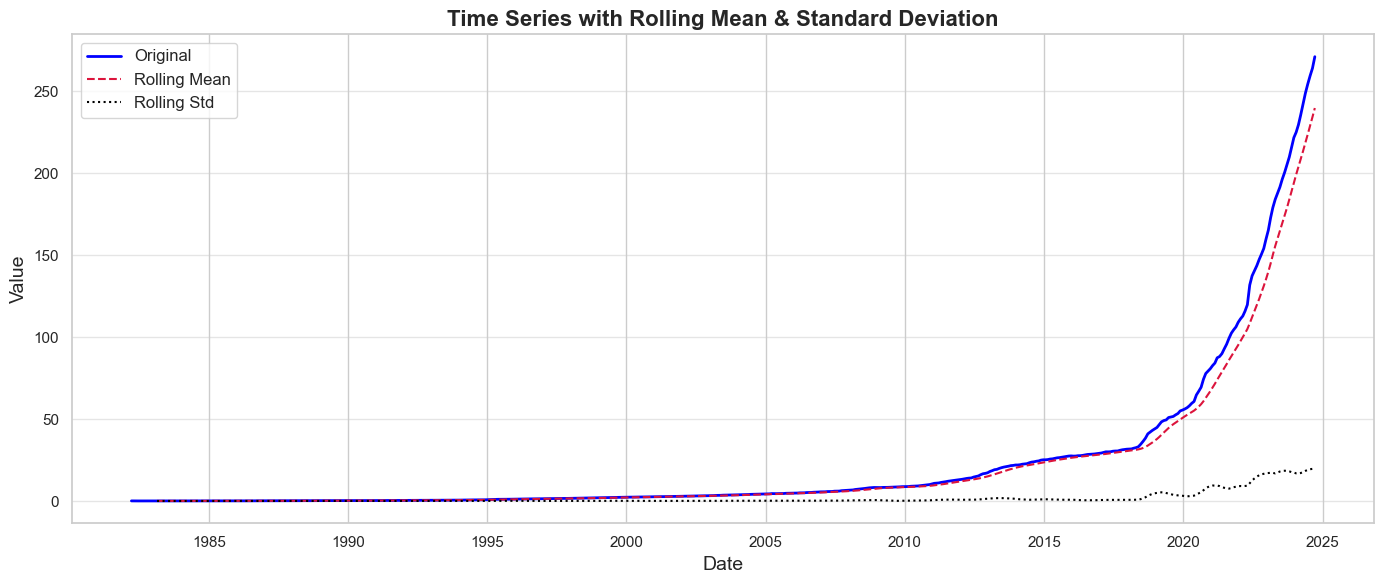

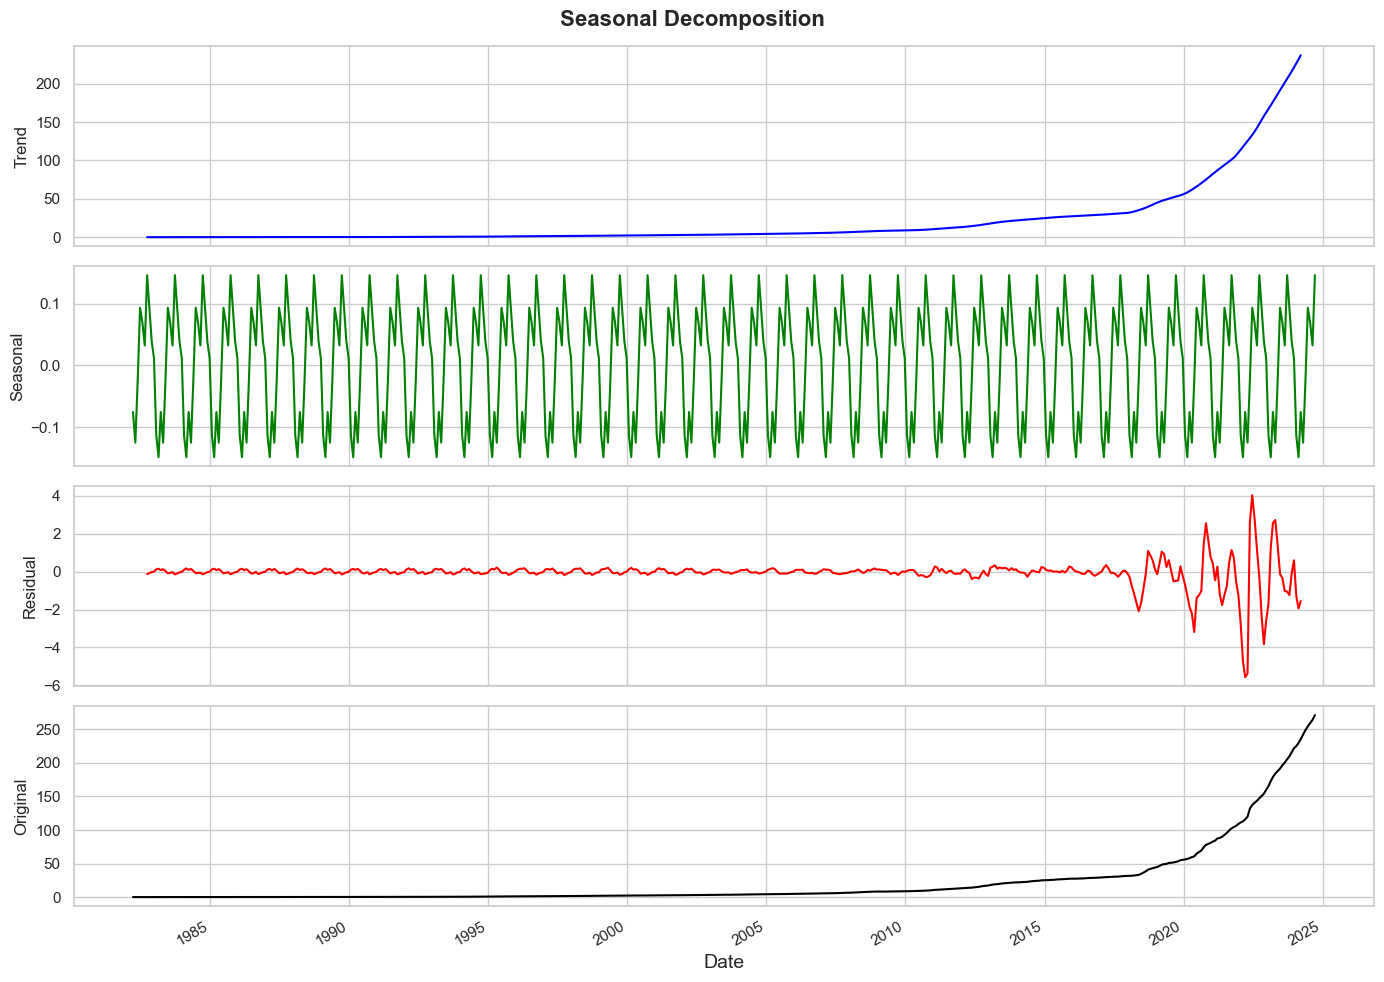

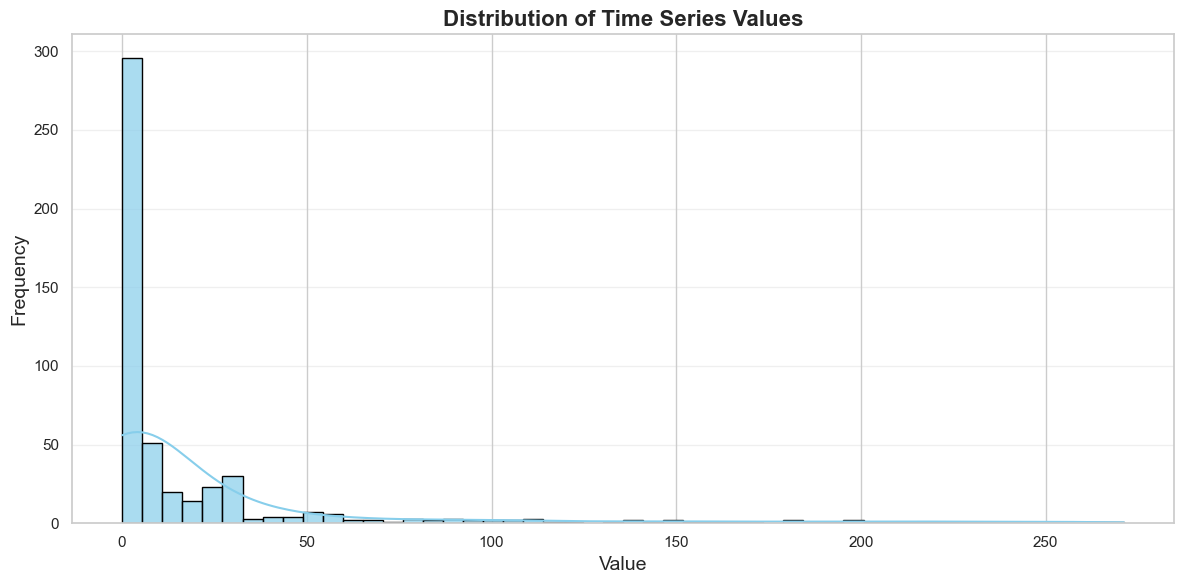

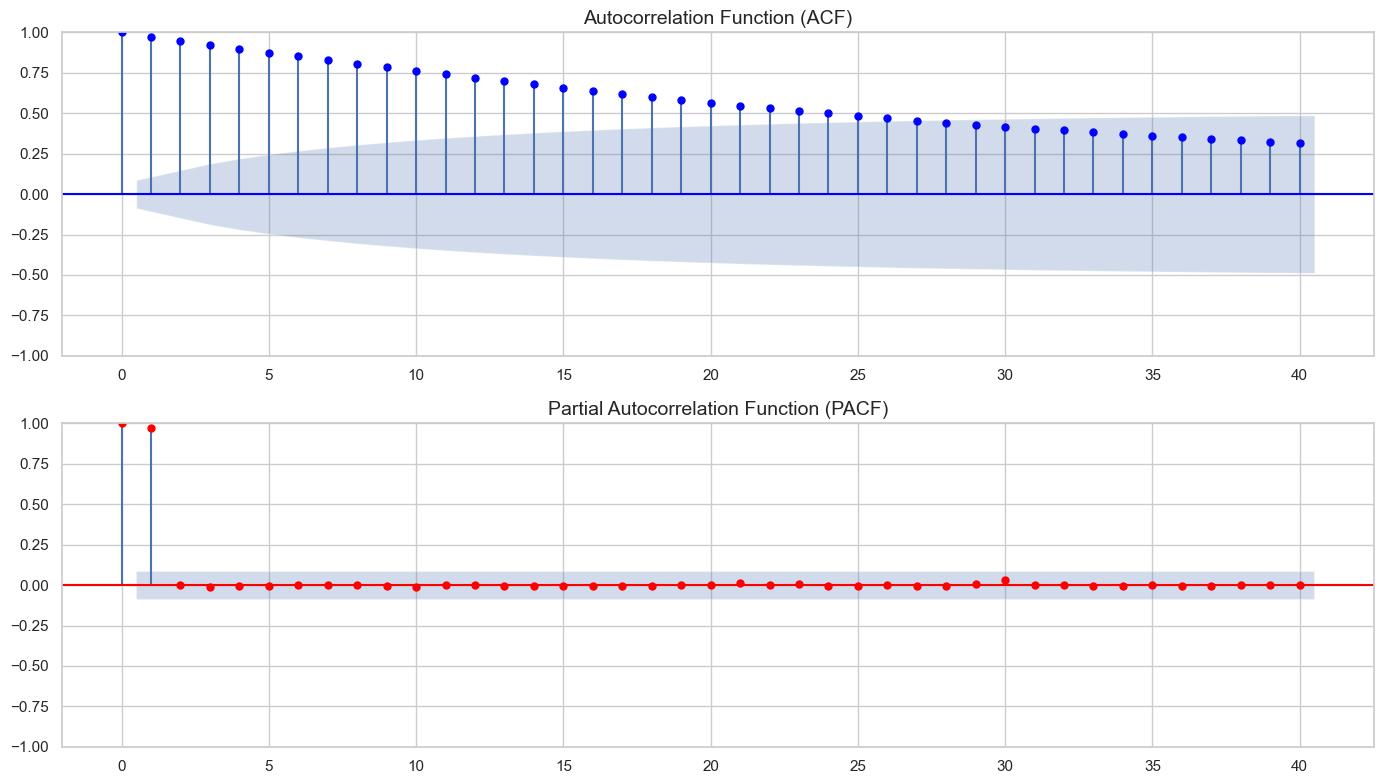

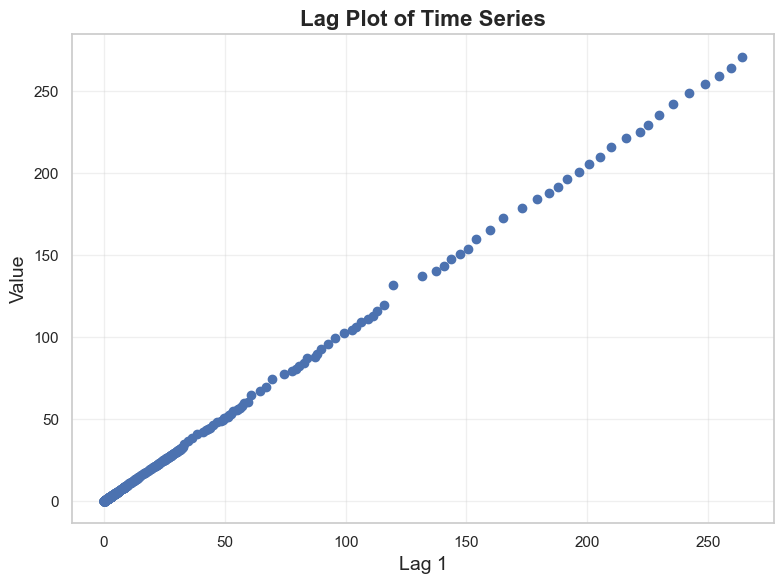

======= Augmented Dickey-Fuller Test Results =======

1. ADF Test Statistic: 3.579829
2. P-value: 1.000000
3. Used Lags: 19
4. Used Observations: 491
5. Critical Values:
	1%: -3.443739
	5%: -2.867444
	10%: -2.569915

Weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary.


In [86]:
complete_time_series_eda(df, column='CPI', rolling_window=12)


Seasonal Decomposition<br>
This graph represents a Seasonal Decomposition of the time series data. This type of decomposition is typically done to break down the time series into several components to better understand the underlying patte

1. Trend Component (Top Panel - Blue Line):
- The trend component represents the long-term progression or direction in the time series data.
- In this graph, the trend starts very low and remains flat until approximately 2010, after which there is a noticeable upward trend, accelerating steeply from around 2020. This indicates a rapid increase in the overall value of the time series, which could be reflective of exponential growth in whatever phenomenon this data represents.
2. Seasonal Component (Second Panel - Green Line):<br>
- The seasonal component captures the recurring patterns or cycles that repeat at regular intervals (e.g., monthly, yearly).
- Here, we see a well-defined periodic pattern with regular peaks and troughs, which suggests that there is a repeating seasonal effect in the data.
- The seasonal fluctuations appear stable throughout the entire timeline, indicating that these seasonal changes are consistent over time.
3. Residual Component (Third Panel - Red Line):<br>
- The residual component represents the random noise or irregular variations in the time series after accounting for trend and seasonal components.
- From the graph, the residual values are relatively stable and close to zero for most of the time, but starting from around 2015, there is an increase in the residual variation, particularly in the form of spikes.
- These increased residual values suggest that the data is becoming more unpredictable or noisy in recent years, indicating that there may be additional factors influencing the data that are not captured by the trend or seasonal components.
4. Original Component (Bottom Panel - Black Line):<br>
- This panel shows the original time series data.
- Similar to the trend component, we can observe that the data remains fairly steady until around 2010-2015, after which there is a very steep rise. The pattern indicates exponential-like growth in recent years, which aligns with the trend component.


Lag Plot<br>
- The points in the lag plot form a distinct and strong linear pattern along a diagonal line, suggesting a strong positive correlation between each observation and its immediate preceding value.
- This means that the time series is highly autocorrelated, which indicates that the current values are heavily dependent on the previous values. In other words, the series is persistent, which is common in trending time series data.

## Handle outliers and High volatility

<h2>Jump Detection and Smoothing</h2>

<p>In this section, we identify and handle sudden jumps or outliers in the time series data to ensure a smoother trend for analysis and forecasting. Below are the steps involved:</p>

<h3>1. Detect Jumps</h3>
<ul>
  <li><strong>Function:</strong> <code>detect_jumps(data, threshold=0.1)</code></li>
  <li><strong>Purpose:</strong> Detect abrupt changes in the data using a relative change threshold.</li>
  <li><strong>Outputs:</strong>
    <ul>
      <li>Original data</li>
      <li>Percentage change</li>
      <li>Flags indicating where jumps occurred</li>
    </ul>
  </li>
</ul>

<h3>2. Remove Jumps</h3>
<ul>
  <li><strong>Function:</strong> <code>remove_jumps(data, threshold=0.1, method='interpolate')</code></li>
  <li><strong>Purpose:</strong> Handle detected jumps using one of three methods:
    <ul>
      <li><strong>Interpolate:</strong> Replace jumps with linear interpolation.</li>
      <li><strong>Rolling Mean:</strong> Smooth jumps using a rolling average.</li>
      <li><strong>Replace:</strong> Replace jumps with the previous value.</li>
    </ul>
  </li>
  <li><strong>Output:</strong> A smoothed time series with outliers removed or adjusted.</li>
</ul>

<h3>3. Visualize Detected Jumps</h3>
<ul>
  <li><strong>Plot:</strong> 
    <ul>
      <li>Original data (black, dashed)</li>
      <li>Smoothed data after interpolation (blue)</li>
      <li>Detected jumps (red markers)</li>
    </ul>
  </li>
  <li><strong>Purpose:</strong> Compare original and smoothed data, highlighting jumps.</li>
</ul>


In [87]:
# def detect_jumps(data, threshold=0.1):
#     data = data.copy()
#     pct_change = data.pct_change().abs() 
#     jumps = pct_change > threshold        # Detect jumps
    
#     jump_df = pd.DataFrame({
#         'Original Data': data,
#         'Pct Change': pct_change,
#         'Jump Detected': jumps,
#     })

#     return jump_df

# def remove_jumps(data, threshold=0.1, method='interpolate'):
#     data = data.copy()
#     pct_change = data.pct_change().abs()
#     jumps = pct_change > threshold

#     # Handle jumps
#     if method == 'interpolate':
#         data[jumps] = np.nan
#         data = data.interpolate(method='linear')
#     elif method == 'rolling_mean':
#         data[jumps] = np.nan
#         data = data.fillna(data.rolling(window=3, min_periods=1).mean())
#     elif method == 'replace':
#         data[jumps] = np.nan
#         data = data.fillna(method='ffill')  # Replace with the previous value

#     return data

# # Example Usage
# threshold = 0.1
# jump_df = detect_jumps(df['CPI'], threshold=threshold)
# df['CPI_interpolate'] = remove_jumps(df['CPI'], threshold=threshold, method='interpolate')

# # Add smoothed values to the DataFrame for comparison
# jump_df['Smoothed Data'] = df['CPI_interpolate']

# jumps_detected = jump_df[jump_df['Jump Detected']]
# print(jumps_detected)

# # Visualize jumps
# plt.figure(figsize=(14, 8))
# plt.plot(df['CPI'], label='Original Data', color='black', linestyle='--', alpha=0.7)
# plt.plot(df['CPI_interpolate'], label='Smoothed Data (Interpolate)', color='blue')
# plt.scatter(jumps_detected.index, jumps_detected['Original Data'], color='red', label='Detected Jumps')
# plt.title('Detected Jumps and Smoothed Data')
# plt.xlabel('Date')
# plt.ylabel('CPI')
# plt.legend()
# plt.grid(True)
# plt.show()


<h2>Data Transformation</h2>

<p>To stabilize variance and improve the stationarity of the time series, we apply different transformations to the data. The function allows for flexible selection of transformation types and visual comparison of results.</p>

<h3>1. Supported Transformation Types</h3>
<ul>
  <li><strong>Log Transformation:</strong> Applies a natural log to compress large values and stabilize variance.</li>
  <li><strong>Box-Cox Transformation:</strong> Transforms positive values to approximate a normal distribution.</li>
  <li><strong>Yeo-Johnson Transformation:</strong> Similar to Box-Cox but handles both positive and negative values.</li>
  <li><strong>Square Root Transformation:</strong> Compresses data by taking the square root of values.</li>
  <li><strong>Min-Max Scaling:</strong> Scales data to a range between 0 and 1 for normalization.</li>
</ul>

<h3>2. Visualization</h3>
<p>When <code>visualize=True</code>, the function generates side-by-side plots for:
<ul>
  <li>Original data</li>
  <li>Transformed data (with the chosen transformation applied)</li>
</ul>
These plots help visually assess the impact of the transformation on the series.</p>

<h3>3. Error Handling</h3>
<ul>
  <li>The function validates input to ensure compatibility with the chosen transformation.</li>
  <li>For example, Box-Cox transformation raises an error if the data contains non-positive values.</li>
</ul>



In [88]:


def choose_data_transformation(data, transformation_type="log", visualize=False):
    # Ensure data is a NumPy array for easier transformation
    data = np.array(data)

    if transformation_type == "log":
        # Log Transformation (adding a small constant to avoid log(0))
        transformed_data = np.log(data + 1e-9)

    elif transformation_type == "boxcox":
        # Box-Cox Transformation (only works for positive data)
        if np.any(data <= 0):
            raise ValueError("Box-Cox transformation requires all data to be positive.")
        transformed_data, _ = boxcox(data)

    elif transformation_type == "yeo_johnson":
        # Yeo-Johnson Power Transformation (can handle positive and negative values)
        transformer = PowerTransformer(method='yeo-johnson')
        transformed_data = transformer.fit_transform(data.reshape(-1, 1)).flatten()

    elif transformation_type == "sqrt":
        transformed_data = np.sqrt(data + 1e-9)
    elif transformation_type == "minmax":
        # Min-Max Scaling
        scaler = MinMaxScaler()
        transformed_data = scaler.fit_transform(data.reshape(-1, 1)).flatten()

    else:
        raise ValueError("Unsupported transformation type. Choose among 'log', 'boxcox', 'yeo_johnson', 'sqrt'.")

    # Visualize the original and transformed data
    if visualize:
        plt.figure(figsize=(14, 6))

        plt.subplot(1, 2, 1)
        plt.plot(data, label='Original Data', color='blue')
        plt.title('Original Data')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(transformed_data, label=f'Transformed Data ({transformation_type})', color='red')
        plt.title(f'{transformation_type.title()} Transformation')
        plt.legend()

        plt.tight_layout()
        plt.show()

    return transformed_data



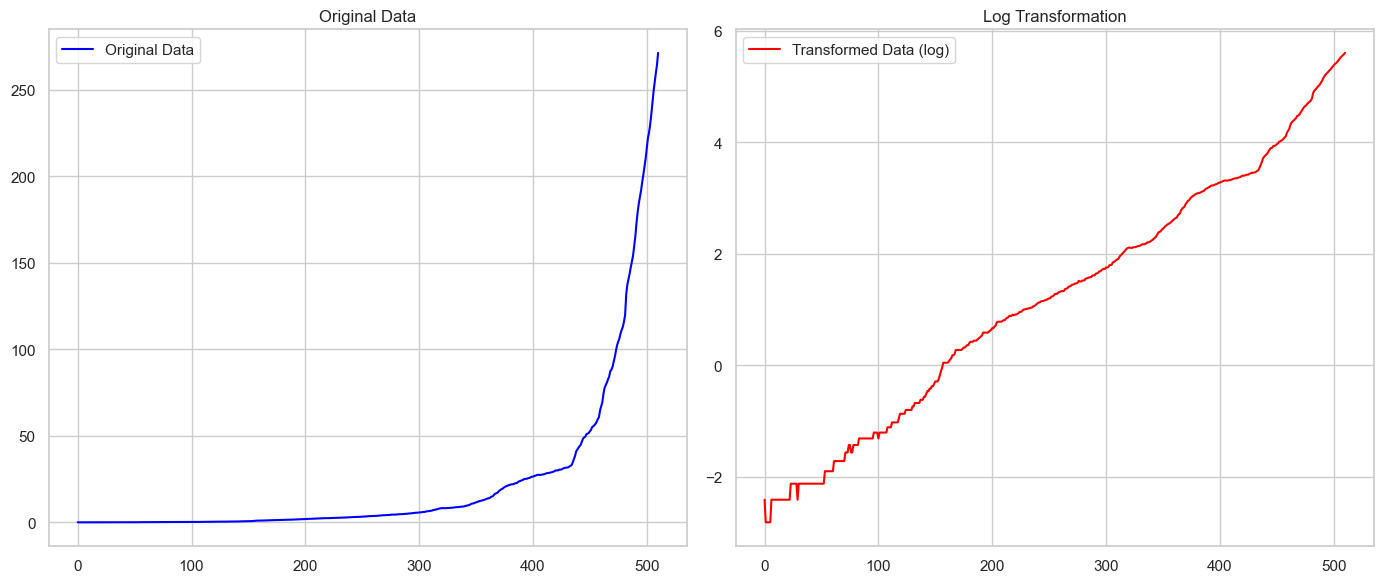

In [89]:
df['CPI'] = choose_data_transformation(df['CPI'], transformation_type='log', visualize=True)

# Data Splitting

Split the data into training and testing sets


In [90]:
train, test =df[df.index.year <= 2017], df[df.index.year > 2017] 

# Model Building and Selection

<h2>SARIMA Model Selection</h2>

<p>The SARIMA (Seasonal AutoRegressive Integrated Moving Average) model is used to forecast seasonal time series data. This section explains how we use the <code>auto_arima</code> function to identify the best model parameters for SARIMA.</p>

<h3>Key Steps</h3>
<ul>
  <li><strong>Seasonality:</strong> The parameter <code>seasonal=True</code> enables the model to account for repeating patterns in the data.</li>
  <li><strong>Parameter Ranges:</strong>
    <ul>
      <li><code>p, q</code>: Non-seasonal AR and MA terms.</li>
      <li><code>P, Q</code>: Seasonal AR and MA terms.</li>
      <li><code>d, D</code>: Orders of differencing for non-seasonal and seasonal trends, respectively.</li>
    </ul>
  </li>
  <li><strong>Seasonal Period:</strong> Set to <code>m=12</code> for monthly data, assuming 12 months per cycle.</li>
  <li><strong>Stepwise Search:</strong> The <code>stepwise=True</code> parameter speeds up the model selection process by iteratively testing parameter combinations.</li>
</ul>

<h3>Trace Output</h3>
<p>Enabling <code>trace=True</code> provides a detailed log of the parameter search process, including the AIC (Akaike Information Criterion) values for each tested combination. This helps identify the optimal SARIMA model based on the lowest AIC score.</p>




In [91]:
#SARIMA
stepwise_fit = auto_arima(df['CPI'],
                          start_p=0, max_p=12,        # Range for AR (p) parameter
                          start_q=0, max_q=12,        # Range for MA (q) parameter
                          d=None,                    # Automatically detect differencing order (d)
                          seasonal=True,             # Enable seasonal components
                          start_P=0, max_P=4,        # Range for seasonal AR (P)
                          start_Q=0, max_Q=4,        # Range for seasonal MA (Q)
                          D=None,                    # Automatically detect seasonal differencing order (D)
                          m=12,                      # Set the seasonal period (monthly data assumed here)
                          trace=True,                # Enable verbose output to trace model selection
                          error_action="ignore",     # Ignore errors during fitting
                          suppress_warnings=True,    # Suppress warnings for cleaner output
                          stepwise=True,             # Use stepwise algorithm for faster convergence
                          n_jobs=-1) 




Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[12] intercept   : AIC=-1782.777, Time=0.06 sec
 ARIMA(1,1,0)(1,0,0)[12] intercept   : AIC=-1786.283, Time=0.85 sec
 ARIMA(0,1,1)(0,0,1)[12] intercept   : AIC=-1786.717, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[12]             : AIC=-1717.907, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[12] intercept   : AIC=-1787.232, Time=0.26 sec
 ARIMA(0,1,1)(1,0,0)[12] intercept   : AIC=-1787.101, Time=0.85 sec
 ARIMA(0,1,1)(1,0,1)[12] intercept   : AIC=-1792.855, Time=1.73 sec
 ARIMA(0,1,1)(2,0,1)[12] intercept   : AIC=-1791.240, Time=2.30 sec
 ARIMA(0,1,1)(1,0,2)[12] intercept   : AIC=-1790.112, Time=1.35 sec
 ARIMA(0,1,1)(0,0,2)[12] intercept   : AIC=-1789.065, Time=3.38 sec
 ARIMA(0,1,1)(2,0,0)[12] intercept   : AIC=-1790.921, Time=1.19 sec
 ARIMA(0,1,1)(2,0,2)[12] intercept   : AIC=-1791.063, Time=4.72 sec
 ARIMA(0,1,0)(1,0,1)[12] intercept   : AIC=-1784.349, Time=0.31 sec
 ARIMA(1,1,1)(1,0,1)[12] intercept   : AIC=-1793.922, Time=1.84 sec
 ARIM

In [92]:
# #ARIMA

# print("Starting ARIMA model selection...\n")
# stepwise_fit = auto_arima(df['CPI'],
#                           start_p=0, max_p=5,       # AR terms
#                           start_q=0, max_q=5,       # MA terms
#                           d=None,                  # Automatically detect differencing order
#                           seasonal=False,          # No seasonality
#                           trace=True,              # Trace the process
#                           error_action="ignore",   # Ignore model errors
#                           suppress_warnings=True,  # Suppress warnings
#                           information_criterion='bic',  # Use BIC for selection
#                           stepwise=True)  


In [93]:
def extract_summary_items(model):
    summary_dict = {}
    
    # Extract AIC and BIC
    summary_dict['AIC'] = model.aic()
    summary_dict['BIC'] = model.bic()
    
    # Extract coefficients information
    params = model.params()
    pvalues = model.pvalues()
    bse = model.bse()
    coefficients = []
    
    for coef_name, coef_value, std_err, p_value in zip(params.index, params.values, bse.values, pvalues.values):
        coefficients.append((coef_name, coef_value, std_err, p_value))
    summary_dict['coefficients'] = coefficients
    
    # Extract Ljung-Box test results (using the residuals)
    ljung_box_test = sm.stats.acorr_ljungbox(model.resid(), lags=[10], return_df=True).iloc[0]
    summary_dict['ljung-box'] = {
        'test_statistic': ljung_box_test['lb_stat'],
        'p_value': ljung_box_test['lb_pvalue']
    }

    # Extract Jarque-Bera test results for normality
    jarque_bera_test = sm.stats.jarque_bera(model.resid())
    summary_dict['jarque-bera'] = {
        'test_statistic': jarque_bera_test[0],
        'p_value': jarque_bera_test[1]
    }

    # Extract Heteroskedasticity test results if exogenous variables are available
    if hasattr(model, 'exog') and model.exog is not None:
        exog = model.exog
        if exog.shape[1] == 1:
            exog = sm.add_constant(exog, has_constant='add')
        het_test = sm.stats.het_breuschpagan(model.resid(), exog)
        summary_dict['heteroskedasticity'] = {
            'test_statistic': het_test[0],
            'p_value': het_test[1]
        }
    
    return summary_dict

def interpret_summary_items(summary_items):
    interpretation = []

    for key, value in summary_items.items():
        key = key.lower()  # Convert key to lowercase for easier matching
        
        if key == "aic":
            interpretation.append("**AIC (Akaike Information Criterion):**")
            interpretation.append(f"AIC Value: {value:.2f}")
            interpretation.append("- The AIC value helps in model selection, balancing the model's goodness of fit with its complexity.")
            interpretation.append("- Lower AIC values are preferred as they indicate a better trade-off between accuracy and complexity.")
            if value > 800:
                interpretation.append("- Critical Analysis: The AIC value is relatively high, suggesting that the model may be too complex or not fit well. Consider simplifying the model.\n")
            else:
                interpretation.append("- Critical Analysis: The AIC value is reasonable, indicating an appropriate balance between fit and complexity.\n")
        
        elif key == "bic":
            interpretation.append("**BIC (Bayesian Information Criterion):**")
            interpretation.append(f"BIC Value: {value:.2f}")
            interpretation.append("- The BIC penalizes model complexity more heavily than AIC, favoring simpler models.")
            interpretation.append("- Similar to AIC, lower BIC values suggest a better model.")
            if value > 850:
                interpretation.append("- Critical Analysis: The BIC value is high, indicating the model might be overfitting or overly complex.\n")
            else:
                interpretation.append("- Critical Analysis: The BIC value indicates an acceptable level of complexity.\n")

        elif key == "coefficients":
            interpretation.append("**Model Coefficients and Their Significance:**")
            interpretation.append("The coefficients describe how past values (AR) or past errors (MA) affect future values.")
            interpretation.append("Below is the analysis of the coefficient table:\n")
            for coef in value:
                coef_name, coef_value, std_err, p_value = coef
                interpretation.append(f"- **{coef_name}:** Coefficient value is {coef_value:.2f}, with a standard error of {std_err:.2f}.")
                if p_value < 0.05:
                    interpretation.append(f"  - p-value ({p_value:.3f}) indicates this coefficient is statistically significant.")
                else:
                    interpretation.append(f"  - p-value ({p_value:.3f}) suggests this coefficient is not statistically significant, consider removing it for simplicity.")
            interpretation.append("")

        elif key == "ljung-box":
            interpretation.append("**Ljung-Box Test (Residual Independence):**")
            interpretation.append(f"Ljung-Box Test Statistic: {value['test_statistic']:.2f}, p-value: {value['p_value']:.3f}")
            if value['p_value'] > 0.05:
                interpretation.append("- The p-value is greater than 0.05, indicating that the residuals are likely independent, which suggests a good model fit.")
            else:
                interpretation.append("- Critical Analysis: The p-value is below 0.05, indicating residual autocorrelation, which means the model may need improvement.\n")

        elif key == "jarque-bera":
            interpretation.append("**Jarque-Bera Test (Normality of Residuals):**")
            interpretation.append(f"Jarque-Bera Test Statistic: {value['test_statistic']:.2f}, p-value: {value['p_value']:.3f}")
            if value['p_value'] > 0.05:
                interpretation.append("- The p-value is greater than 0.05, suggesting that the residuals are normally distributed.")
            else:
                interpretation.append("- Critical Analysis: The p-value is less than 0.05, indicating that the residuals deviate from normality, which could affect prediction accuracy.\n")

        elif key == "heteroskedasticity":
            interpretation.append("**Heteroskedasticity Test (Constant Variance of Residuals):**")
            interpretation.append(f"Heteroskedasticity Test Statistic: {value['test_statistic']:.2f}, p-value: {value['p_value']:.3f}")
            if value['p_value'] > 0.05:
                interpretation.append("- The p-value indicates homoscedasticity, meaning the residuals have constant variance, which is a good sign.")
            else:
                interpretation.append("- Critical Analysis: Residuals show signs of heteroskedasticity, indicating the variance may not be constant and suggesting potential outliers or model deficiencies.\n")

        else:
            interpretation.append(f"**{key.title()}:**")
            interpretation.append(f"Value: {value}")
            interpretation.append("- Note: No specific interpretation logic available for this key.\n")

    return "\n".join(interpretation)





In [94]:
stepwise_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  511
Model:               SARIMAX(2, 1, 2)   Log Likelihood                 912.502
Date:                Sun, 24 Nov 2024   AIC                          -1813.004
Time:                        15:52:09   BIC                          -1787.598
Sample:                             0   HQIC                         -1803.043
                                - 511                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0247      0.004      6.980      0.000       0.018       0.032
ar.L1          0.2767      0.028      9.806      0.000       0.221       0.332
ar.L2         -0.8522      0.029    -29.575      0.000      -0.909      -0.796
ma.L1         -0.4093      0.022    -18.884      0.000      -0.452      -0.367
ma.L2          0.9518      0.025     38.676      0.000       0.904       1.000
sigma2         0.0017   3.62e-05     45.595      0.000       0.002       0.002
===================================================================================
Ljung-Box (L1) (Q):                   0.27   Jarque-Bera (JB):             35293.11
Prob(Q):                              0.60   Prob(JB):                         0.00
Heteroskedasticity (H):               0.06   Skew:                            -0.09
Prob(H) (two-sided):                  0.00   Kurtosis:                        43.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [95]:
summary_items = extract_summary_items(stepwise_fit)
interpret = interpret_summary_items(summary_items)
print(interpret)

**AIC (Akaike Information Criterion):**
AIC Value: -1813.00
- The AIC value helps in model selection, balancing the model's goodness of fit with its complexity.
- Lower AIC values are preferred as they indicate a better trade-off between accuracy and complexity.
- Critical Analysis: The AIC value is reasonable, indicating an appropriate balance between fit and complexity.

**BIC (Bayesian Information Criterion):**
BIC Value: -1787.60
- The BIC penalizes model complexity more heavily than AIC, favoring simpler models.
- Similar to AIC, lower BIC values suggest a better model.
- Critical Analysis: The BIC value indicates an acceptable level of complexity.

**Model Coefficients and Their Significance:**
The coefficients describe how past values (AR) or past errors (MA) affect future values.
Below is the analysis of the coefficient table:

- **intercept:** Coefficient value is 0.02, with a standard error of 0.00.
  - p-value (0.000) indicates this coefficient is statistically significant.


# Model Evaluation

## Evaluate the model performance


<h2>Yearly SARIMAX Forecasting and Evaluation (2017-2024)</h2>

<p>This section performs yearly forecasting using the SARIMAX model, evaluates the results against real data, and calculates metrics such as MSE, MAE, and R<sup>2</sup> for each year and overall.</p>

<h3>Steps Involved</h3>
<ol>
  <li><strong>Train SARIMAX Model:</strong> For each year, train the model using data up to the previous year.</li>
  <li><strong>Forecast:</strong> Predict CPI values for the current year and compare with actual values.</li>
  <li><strong>Plot Forecasts:</strong> Each year's forecast is plotted in a unique color for clarity.</li>
  <li><strong>Metrics Calculation:</strong> Calculate the following metrics for each year:
    <ul>
      <li><strong>MSE:</strong> Mean Squared Error</li>
      <li><strong>MAE:</strong> Mean Absolute Error</li>
      <li><strong>R<sup>2</sup> Score:</strong> Coefficient of Determination</li>
    </ul>
  </li>
  <li><strong>Overall Evaluation:</strong> Aggregate all yearly results to compute overall metrics for the period (2017-2024).</li>
</ol>

<h3>Visualizations</h3>
<ul>
  <li><strong>Forecast Plot:</strong> 
    <ul>
      <li>Training data (blue)</li>
      <li>Real CPI data (orange)</li>
      <li>Forecasted values for each year (various colors)</li>
    </ul>
  </li>
</ul>



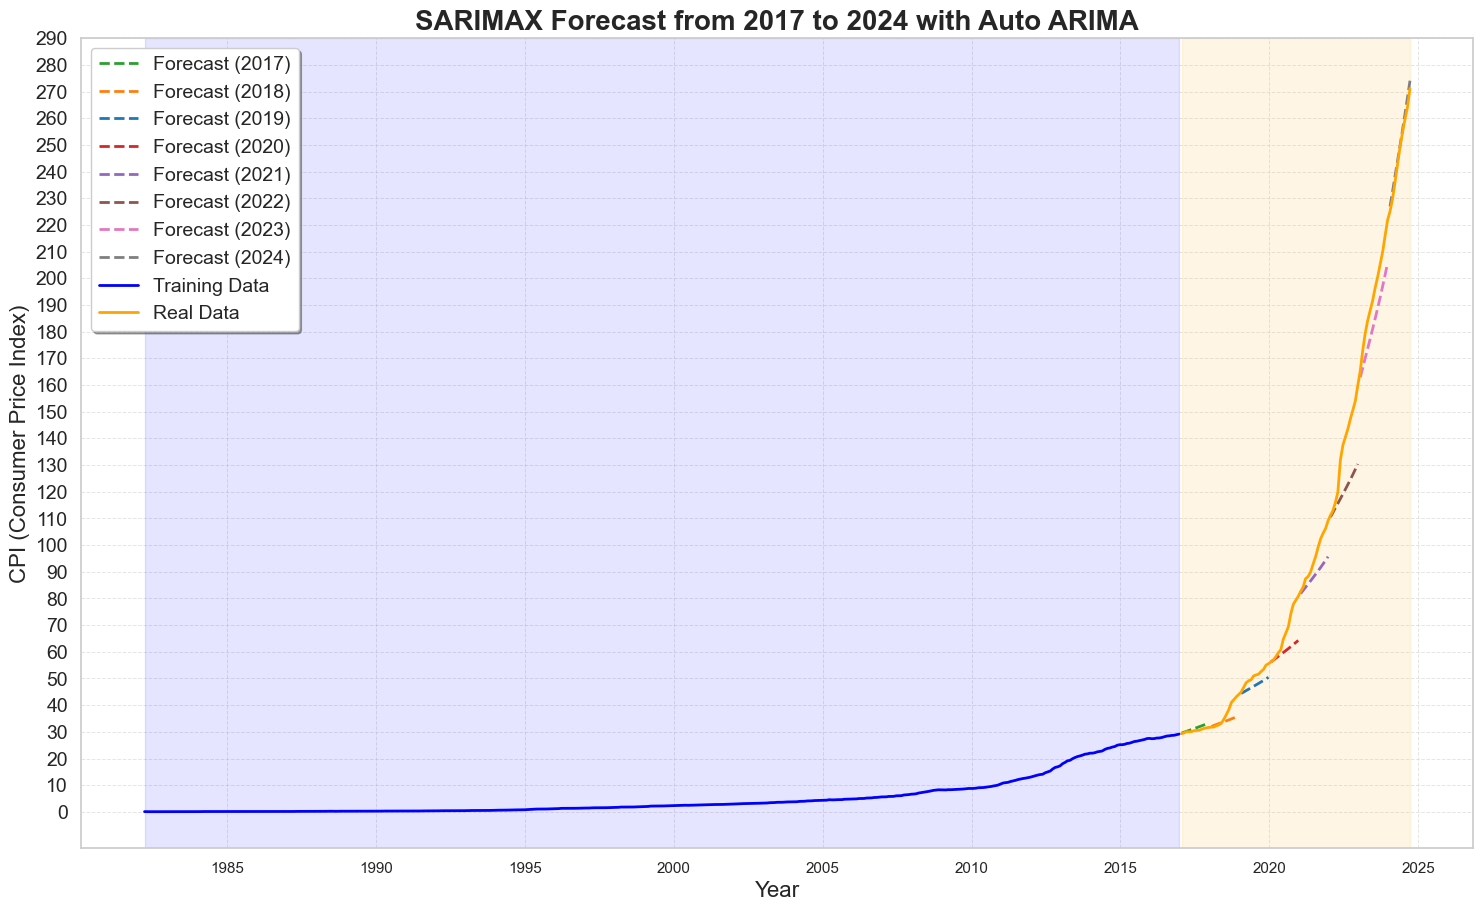

Year: 2017
  MSE: 0.0011
  MAE: 0.0286
---------------------------
Year: 2018
  MSE: 0.0128
  MAE: 0.0833
---------------------------
Year: 2019
  MSE: 0.0052
  MAE: 0.0680
---------------------------
Year: 2020
  MSE: 0.0180
  MAE: 0.1018
---------------------------
Year: 2021
  MSE: 0.0066
  MAE: 0.0695
---------------------------
Year: 2022
  MSE: 0.0180
  MAE: 0.1134
---------------------------
Year: 2023
  MSE: 0.0034
  MAE: 0.0560
---------------------------
Year: 2024
  MSE: 0.0001
  MAE: 0.0081
---------------------------
Overall Evaluation Metrics from 2017 to 2024:
  Overall MSE: 0.0084
  Overall MAE: 0.0680
  Overall R2 Score: 0.9833


In [96]:
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Initialize the base year for training and forecast end year
start_year = 2017
end_year = 2024

plt.figure(figsize=(16, 10))

# Define a list of colors for each forecasted year
forecast_colors = ['#2ca02c', '#ff7f0e', '#1f77b4', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f']

# Initialize lists to store evaluation metrics
mse_list = []
mae_list = []
r2_list = []

# Initialize arrays to store all forecasted and real values for overall evaluation
all_forecasted_values = []
all_real_values = []

# Loop through each year and forecast
for idx, year in enumerate(range(start_year, end_year + 1)):
    # Train the SARIMAX model using data up to the year before the current year
    sarimax_model = SARIMAX(
        df[df.index.year < year]['CPI'],
        order=stepwise_fit.order,
        seasonal_order=stepwise_fit.seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarimax_results = sarimax_model.fit(disp=False)

    # Forecast for the current year
    forecast_steps = len(df[df.index.year == year]['CPI'])
    forecast = sarimax_results.get_forecast(steps=forecast_steps)
    forecast_index = df[df.index.year == year]['CPI'].index[:forecast_steps]
    forecast_mean = forecast.predicted_mean

    # Plot the forecasted results with a different color for each year
    plt.plot(forecast_index, np.exp(forecast_mean), label=f'Forecast ({year})', color=forecast_colors[idx % len(forecast_colors)], linestyle='--', linewidth=2)

    # Collect all forecasted and real values for overall evaluation
    real_values = df[df.index.year == year]['CPI']
    all_real_values.extend(real_values)
    all_forecasted_values.extend(forecast_mean)

    # Calculate evaluation metrics for the current year
    mse = mean_squared_error(real_values, forecast_mean)
    mae = mean_absolute_error(real_values, forecast_mean)
    r2 = r2_score(real_values, forecast_mean)

    # Store the metrics
    mse_list.append(mse)
    mae_list.append(mae)
    r2_list.append(r2)

# Plot the training data
plt.plot(np.exp(df[df.index.year < start_year]['CPI']), label='Training Data', color='blue', linewidth=2)
plt.plot(np.exp(df[(df.index.year >= start_year) & (df.index.year <= end_year)]['CPI']), label='Real Data', color='orange', linewidth=2)

# Add grid lines to the plot
plt.grid(True, which='both', linestyle='--', linewidth=0.7, alpha=0.5)

# Add labels for axes
plt.xlabel('Year', fontsize=16)
plt.ylabel('CPI (Consumer Price Index)', fontsize=16)

# Customize the y-axis to add more ticks
plt.yticks(np.arange(0, max(np.exp(df['CPI'])) * 1.1, step=10), fontsize=14)

# Set title with larger font size
plt.title('SARIMAX Forecast from 2017 to 2024 with Auto ARIMA', fontsize=20, fontweight='bold')

# Adjust legend for better visibility
plt.legend(loc='upper left', fontsize=14, frameon=True, shadow=True)

# Highlight training and forecasting intervals with shading
plt.axvspan(df[df.index.year < start_year].index.min(), df[df.index.year < start_year].index.max(), color='blue', alpha=0.1, label='Training Period')
plt.axvspan(df[df.index.year >= start_year].index.min(), df[df.index.year <= end_year].index.max(), color='orange', alpha=0.1, label='Forecasting Period')

plt.show()

# Display evaluation metrics for each year
for idx, year in enumerate(range(start_year, end_year + 1)):
    print(f"Year: {year}")
    print(f"  MSE: {mse_list[idx]:.4f}")
    print(f"  MAE: {mae_list[idx]:.4f}")
    # print(f"  R2 Score: {r2_list[idx]:.4f}")
    print("---------------------------")

# Calculate and display overall evaluation metrics
all_real_values = np.array(all_real_values)
all_forecasted_values = np.array(all_forecasted_values)

overall_mse = mean_squared_error(all_real_values, all_forecasted_values)
overall_mae = mean_absolute_error(all_real_values, all_forecasted_values)
overall_r2 = r2_score(all_real_values, all_forecasted_values)

print("Overall Evaluation Metrics from 2017 to 2024:")
print(f"  Overall MSE: {overall_mse:.4f}")
print(f"  Overall MAE: {overall_mae:.4f}")
print(f"  Overall R2 Score: {overall_r2:.4f}")


<h2>Iterative Monthly Forecasting with SARIMAX</h2>

<p>This section explains how to generate monthly forecasts iteratively for a specified horizon (e.g., 12 months) using the SARIMAX model. The results are visualized to compare the original data with the forecasted values.</p>

<h3>Key Steps</h3>
<ol>
  <li><strong>Initialize:</strong> Create a DataFrame to store forecasted values and a copy of the original data to maintain data integrity.</li>
  <li><strong>Iterative Forecasting:</strong> 
    <ul>
      <li>Train the SARIMAX model using the current dataset.</li>
      <li>Forecast one month ahead and append the forecasted value to the dataset.</li>
      <li>Repeat the process for the desired forecast horizon (e.g., 12 months).</li>
    </ul>
  </li>
  <li><strong>Update Forecast DataFrame:</strong> Store the forecasted values with corresponding dates.</li>
  <li><strong>Visualization:</strong> Plot the original data alongside the 12-month forecasts.</li>
</ol>

<h3>Visualization</h3>
<ul>
  <li><strong>Original Data:</strong> Plotted in blue for reference.</li>
  <li><strong>Forecasted Data:</strong> Plotted in orange (dashed line) to show future trends.</li>
</ul>




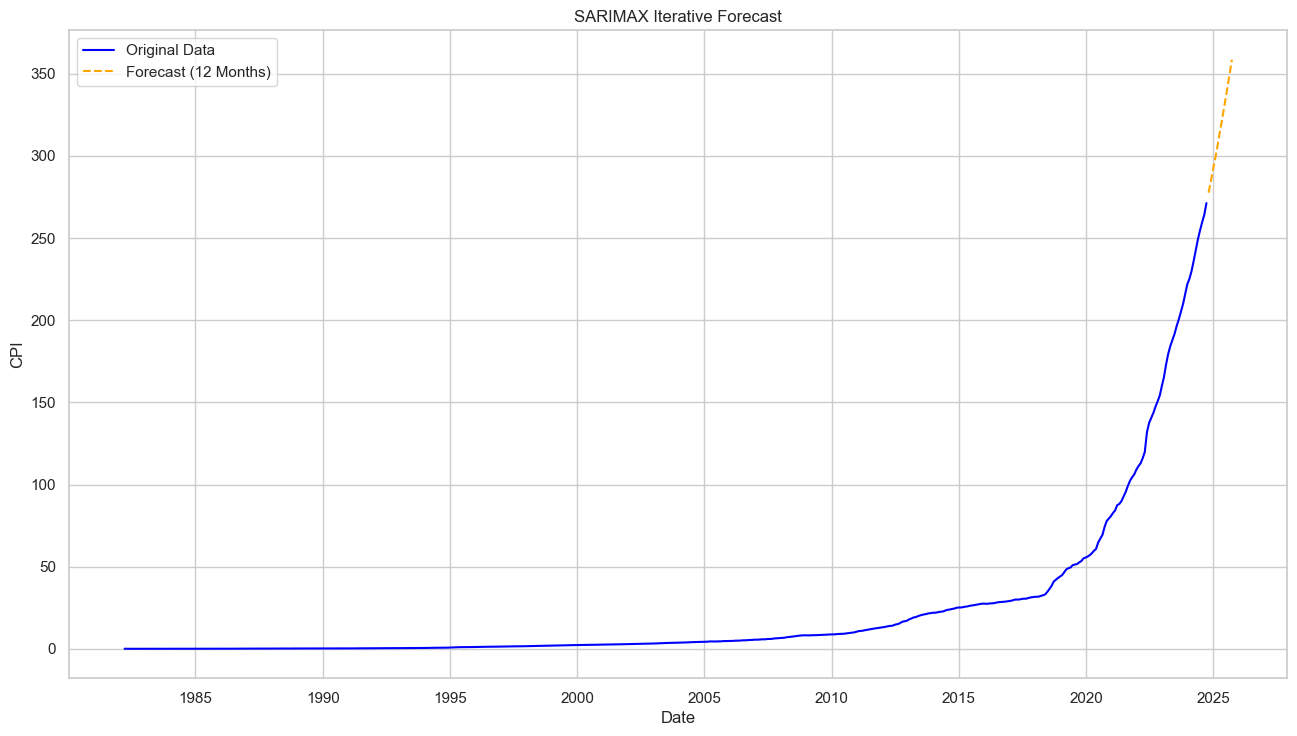

In [97]:
# Initialize a DataFrame to store forecasts
future_forecasts = pd.DataFrame(columns=['Date', 'Forecast'])

# Number of months to forecast
forecast_horizon = 12

# Make a copy of the original data to avoid modifying it
data_with_forecasts = df.copy()

# Iteratively forecast one month at a time
for i in range(forecast_horizon):
    # Train the SARIMAX model on the current data
    sarimax_model = SARIMAX(
        data_with_forecasts['CPI'],
        order=stepwise_fit.order,
        seasonal_order=stepwise_fit.seasonal_order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    sarimax_results = sarimax_model.fit(disp=False)
    
    # Forecast for the next step (1 month)
    forecast_steps = 1
    forecast = sarimax_results.get_forecast(steps=forecast_steps)
    forecast_mean = forecast.predicted_mean.iloc[0]  # Get the forecasted value
    
    # Create the next date to append
    next_date = data_with_forecasts.index[-1] + pd.DateOffset(months=1)
    
    # Append the forecast to the data
    data_with_forecasts.loc[next_date] = forecast_mean
    
    # Store the forecast in the future_forecasts DataFrame
    new_forecast = pd.DataFrame({'Date': [next_date], 'Forecast': [forecast_mean]})
    future_forecasts = pd.concat([future_forecasts, new_forecast], ignore_index=True)

# Set 'Date' as the index for the forecast DataFrame
future_forecasts['Date'] = pd.to_datetime(future_forecasts['Date'])
future_forecasts.set_index('Date', inplace=True)

# Visualize the results

plt.figure(figsize=(14, 8))
plt.plot(np.exp(df['CPI']), label='Original Data', color='blue')
plt.plot(np.exp(future_forecasts['Forecast']), label='Forecast (12 Months)', color='orange', linestyle='--')
plt.title('SARIMAX Iterative Forecast')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.legend()
plt.grid(True)
plt.show()
